This is just a test file to show you why we chose to run DBscan the way we did. Some things here were not implemented in the final pipeline (e.g. the Vincenty distance formula because it's too time consuming) but this is where we found out about many parameters, etc.

In [1]:
# std lib
from collections import OrderedDict
from getpass import getpass
import warnings
from matplotlib.colors import LogNorm
warnings.filterwarnings('ignore') # to suppress some astropy deprecation warnings

# 3rd party
import numpy as np
import pylab as plt
from astropy import utils, io, convolution, wcs, stats
from astropy.visualization import make_lupton_rgb
from astropy.coordinates import name_resolve
from pyvo.dal import sia
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from photutils import find_peaks
from scipy.spatial import cKDTree
from scipy.spatial.distance import pdist, squareform
import healpy as hp
from sklearn.cluster import DBSCAN

%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert
from dl.helpers.crossmatch import xmatch

# set up Simple Image Access (SIA) service
DEF_ACCESS_URL = "http://datalab.noao.edu/sia/des_dr1"
svc = sia.SIAService(DEF_ACCESS_URL)

In [33]:
# To save to virtual space, need to log in your account (not anonymous)
token = ac.login(input('Enter user name (+ENTER): '),getpass('Enter password (+ENTER): '))  

Enter user name (+ENTER): zilishen
Enter password (+ENTER): ········


In [3]:
# create a proper WCS object
def get_wcs(ra,dec,image,fov=1.,unit='deg',projection=("RA---TAN","DEC--TAN")):
    npix = image.shape[0]
    crpix = npix/2 + 1
    cdelt = fov/float(npix)
    w = wcs.WCS(naxis=2)
    w.wcs.cunit = (unit,unit)
    w.wcs.crpix = (crpix,crpix)
    w.wcs.cdelt = np.array((-cdelt,cdelt))
    w.wcs.ctype = projection
    w.wcs.crval = (ra,dec) #coords.ra.to(unit).value, coords.dec.to(unit).value)
    return w

## a convolution filter
def dwarf_filter (ra,dec,fwhm_small=2.0,fwhm_big=20):

    """Differential convolution with 2D Gaussian kernels.
    
       Based on Koposov et al. (2008).
       Code by Ken Mighell and Mike Fitzpatrick.
       Minor edits by RN.
       
       Parameters
       ----------
       ra, dec : float or array
           RA & Dec in degrees.
    
       fwhm_small, fwhm_big : float
           Full-width half maximum sizes of the small and big Gaussian kernels
           to use in convolution, in arcminutes.
    """
    
    x, y = ra, dec

    print("Computing differential convolution")

    # Information about declination (y) [degrees]
    ymean = (y.min() + y.max()) / 2.0
    ydiff_arcmin = (y.max() - y.min()) * 60.0 # convert from degrees to arcmin

    # Information about right ascension (x) [degrees in time]:
    xdiff = x.max() - x.min() # angular separation [degrees (time)] 
    xmean = (x.min() + x.max()) / 2.0

    # convert from degrees in time to separation in angular degrees:
    xdiff_angular = (x.max() - x.min()) * np.cos(ymean*(np.pi/180.0))

    # convert from degress to arcmin
    xdiff_angular_arcmin = xdiff_angular * 60.0 

    # Get the number of one-arcmin pixels in the X and Y directions:
    nx = np.rint(xdiff_angular_arcmin).astype('int')
    ny = np.rint(ydiff_arcmin).astype('int')

    # Create a two-dimensional histogram of the raw counts:
    Counts, xedges, yedges  = np.histogram2d (x, y, (nx,ny) )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    raw_hist = np.rot90(Counts).copy() # hack around Pythonic weirdness

    # Make the small and big Gaussian kernels with a standard deviation
    # of the given FWHM in arcmin^2 pixels.
    kernel_small = convolution.Gaussian2DKernel(fwhm_small/2.35,factor=1)
    kernel_big = convolution.Gaussian2DKernel(fwhm_big/2.35,factor=1)

    # Compute the differential convolution kernels.
    conv_big = convolution.convolve(raw_hist, kernel_big)
    conv_small = convolution.convolve(raw_hist, kernel_small)
    conv_delta = conv_small - conv_big
    delta = conv_delta.copy()

    # Compute statistics and the floor
    mean = np.mean(delta, dtype='float64')
    sigma = np.std(delta, dtype='float64')
    sigmaRaw = np.std(raw_hist,dtype='float64')
    median = np.median(delta) # not used
    floor = mean

    clipped = delta.copy()
    clipped[delta < floor] = floor

    # Return the computed fields.
    return raw_hist, extent, delta, clipped, sigma

In [4]:
def angular_separation(x1,x2):
    """
    Modified from astropy.coordinates.angle_utilities 
    Angular separation between two points on a sphere.
    Parameters
    ----------
    x1, x2: array of float Longitude and latitude in radians.
    each array needs to have two columns, lon(RA) and lat(dec)
    Returns
    -------
    angular separation: float in radians.
    Notes
    -----
    The angular separation is calculated using the Vincenty formula [1]_,
    which is slightly more complex and computationally expensive than
    some alternatives, but is stable at at all distances, including the
    poles and antipodes.
    .. [1] https://en.wikipedia.org/wiki/Great-circle_distance
    """
    sdlon = np.sin(x2[0] - x1[0])
    cdlon = np.cos(x2[0] - x1[0])
    slat1 = np.sin(x1[1])
    slat2 = np.sin(x2[1])
    clat1 = np.cos(x1[1])
    clat2 = np.cos(x2[1])

    num1 = clat2 * sdlon
    num2 = clat1 * slat2 - slat1 * clat2 * cdlon
    denominator = slat1 * slat2 + clat1 * clat2 * cdlon

    return np.arctan2(np.hypot(num1, num2), denominator)
   

In [5]:
def angular_separation_hvs(x1,x2):
    """
    Modified from astropy.coordinates.angle_utilities 
    Angular separation between two points on a sphere.
    Parameters
    ----------
    x1, x2: array of float Longitude and latitude in radians.
    each array needs to have two columns, lon(RA)(lambda) and lat(dec)(phi)
    Returns
    -------
    angular separation: float in radians.
    Notes
    -----
    The angular separation is calculated using the Haversine formula [1]_,
    which is computationally less expensive than
    Vincenty, but is not stable at antipodes.
    .. [1] https://en.wikipedia.org/wiki/Great-circle_distance
    """
    ssqrdlat = np.sin(0.5*(x2[1] - x1[1]))**2
    ssqrdlon = np.sin(0.5*(x2[0] - x1[0]))**2
    clat1 = np.cos(x1[1])
    clat2 = np.cos(x2[1])
    
    return 2*np.arcsin(np.sqrt(ssqrdlat + clat1*clat2*ssqrdlon))
    

In [6]:
df = pd.read_csv('des_dr1_g_i_small_box.csv')

# Sample selection:

### For the initial test, I selected an area around NGC 300 to compare to dwarf filter

(19.999000000000002, 10.001855)

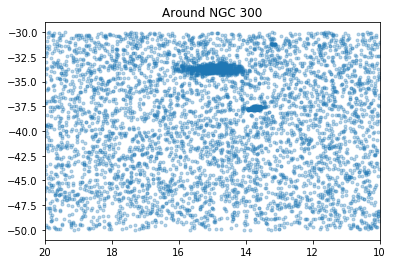

In [7]:
add_N300, = np.where((df['ra'] > 10) & (df['ra'] < 20) & (df['dec'] < -30)  & (df['dec'] > -50) & (df['mag_auto_g'] < 24))
#add_N300, = np.where((df['ra'] > 10) & (df['ra'] < 12) & (df['dec'] < -30)  & (df['dec'] > -35) & (df['mag_auto_g'] < 24))

plt.plot(df['ra'][add_N300],df['dec'][add_N300],'.',alpha=0.3)
plt.title('Around NGC 300')
plt.xlim(df['ra'][add_N300].max(),df['ra'][add_N300].min())

In [8]:
add_half, = np.where(df['dec'] > -10.)
print (len(add_half))

27003


### Testing Healpix: select all stars in the same pixel

In [9]:
# Healpix resolution parameters
n_exp = 2
nside = 2**n_exp #Drlica-Wagner 2015: nside = 4096
npix = 12 * 4**n_exp

print("n_exp =", n_exp, "n_side =", nside, "n_pix =", npix)

n_exp = 2 n_side = 4 n_pix = 192


In [10]:
import collections
# Calculate the area of one pixel (useful for density map)
area = hp.nside2pixarea(nside,degrees=True)
print('area of each pixel = ',area)

# Read in the ra and dec coordinates for each star
lon,lat = df['ra'],df['dec']
df['pix'] = hp.ang2pix(nside,lon,lat,lonlat=True) # Convert to healpy pixel position

# Count how many stars in each pixel
counts = collections.Counter(df['pix'])
pixels, number = np.array(sorted(counts.items())).T

area of each pixel =  214.8591731740587


In [11]:
print(np.where(number>40000))

(array([37, 43]),)


In [12]:
unique_pixels = np.unique(pixels)
i = 26
current_pix = unique_pixels[i]
print (current_pix)

151


In [13]:
add_pix, = np.where(df['pix'] == current_pix)

add_N300 has the indices for NGC 300 box, and add_pix has the i-th healpix indices

In [14]:
ra_rad = df['ra'][add_pix].values*np.pi/180.0
dec_rad = df['dec'][add_pix].values*np.pi/180.0
X = np.column_stack((ra_rad,dec_rad))

In [15]:
print(X.shape)

(106, 2)


In [16]:
import time
t0 = time.time()
dist_hvs = pdist(X,angular_separation_hvs)
t1 = time.time()
square_dist_hvs = squareform(dist_hvs) # DBscan expects square dist. matrix, so this is crucial
print(t1-t0)

0.08815312385559082


In [17]:
print(dist_hvs[:5])

[0.00546136 0.00555188 0.00548806 0.00352453 0.00449963]


# Below: time using Vincenty formula for comparison

In [11]:
t0 = time.time()
dist = pdist(X,angular_separation)
t1 = time.time()
print(t1-t0)
print(dist[:5])

0.5696589946746826
[0.00493739 0.00617327 0.00219636 0.0028414  0.00267817]


# Cluster analysis using DBscan

In [18]:
radius_d = 10./60. #in degrees
radius_r = radius_d*np.pi/180. #in radians
db = DBSCAN(eps=radius_r, min_samples=10, metric='precomputed').fit(square_dist_hvs)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 91


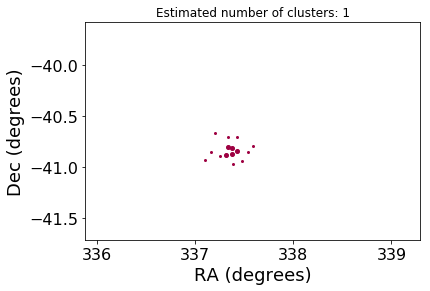

In [19]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

#plt.figure(figsize=(12,12))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 0]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    xy = xy*180.0/np.pi
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor=tuple(col),
             markersize=4)

    xy = X[class_member_mask & ~core_samples_mask]
    xy = xy*180.0/np.pi
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),markeredgecolor=tuple(col),
             markersize=2)

plt.tick_params(axis='both',labelsize=16)
plt.xlabel('RA (degrees)',fontsize=18)
plt.ylabel('Dec (degrees)',fontsize=18)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [20]:
unique_labels_arr = np.array(list(unique_labels))
core_samples_center = np.zeros((len(unique_labels_arr)-1,2))
for i in np.arange(len(unique_labels_arr)):
    if ~(unique_labels_arr[i] == -1):
        class_member_mask = (labels == unique_labels_arr[i])
        xy = X[class_member_mask & core_samples_mask]
        xy = xy*180.0/np.pi
        core_samples_center[i,:] = np.mean(xy, axis=0)

In [21]:
print (core_samples_center)

[[337.3656528 -40.8426202]]


# Run dwarf filter on all stars around these coords.

In [22]:
# columns to query for
columns = '''ra,dec,mag_auto_g,mag_auto_i,magerr_auto_g,magerr_auto_i'''
def queryallstars(ra0,dec0,radius0=5./60.,columns='*'):
    query_template =\
    """SELECT {0:s} FROM des_dr1.main
       WHERE spread_model_r + 3.0*spreaderr_model_r < 0.003 AND spread_model_r > -1 AND 
       flags_r < 4.0 AND flags_g < 4.0 AND
       imaflags_iso_r = 0 AND imaflags_iso_g = 0 AND
       q3c_radial_query(ra,dec,{1:f},{2:f},{3:f})
       
    """.format(columns,ra0,dec0,radius0)
    query0 = query_template # query for stars
    response = qc.query(sql=query0) # using sql argument instead of the default adql
    all_stars = convert(response,'pandas')
    print('Selected {} stars and {} columns'.format(all_stars.shape[0],all_stars.shape[1])) 
    return all_stars

In [23]:
def plotCMD(name, all_stars):
    '''
    Plot CMD and location of all retrieved stars around a candidate galaxy.
    all_stars is a pandas dataframe that contains gmag,imag,ra,dec
    box_stars needs the same columns
    '''

    plt.figure(figsize=(16,8))

    plt.subplot(121)
    plt.plot(all_stars['mag_auto_g']-all_stars['mag_auto_i'],all_stars['mag_auto_g'],'k.')
    plt.xlabel('g-i')
    plt.ylabel('g')
    plt.xlim(-1,3)
    plt.ylim(27,14)
    plt.title("CMD of all stars around "+name)

    plt.subplot(122)
    plt.plot(all_stars['ra'], all_stars['dec'],'k.')
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.title("Location of all stars around "+name)

Selected 829 stars and 6 columns


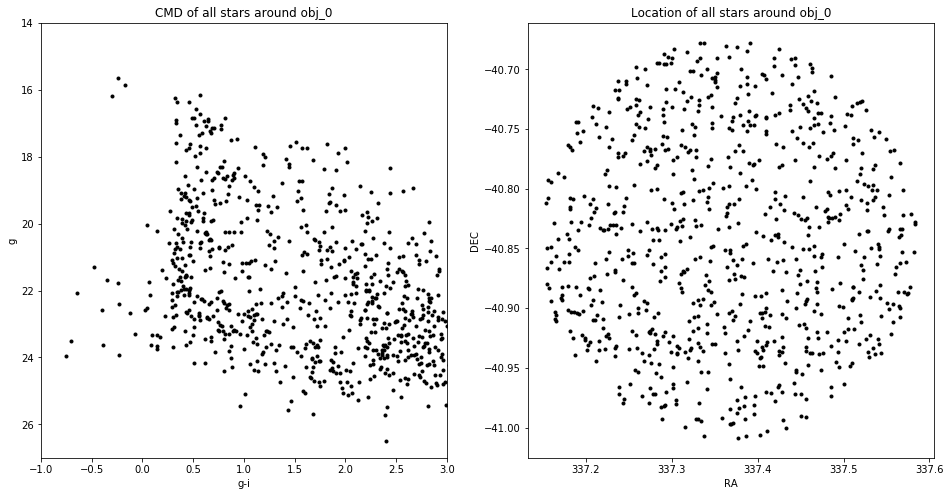

In [24]:
all_stars = {}
for i in np.arange(len(core_samples_center[:,])):
    all_stars[i] = queryallstars(core_samples_center[i,0],core_samples_center[i,1],radius0=radius_d,columns=columns)
    plotCMD('obj_{}'.format(i),all_stars[i])

In [25]:
small_k, big_k = 2, 60.  # kernel sizes in arcminutes
raw, extent, delta, clipped, dsigma = dwarf_filter(all_stars[0]['ra'],all_stars[0]['dec'],
                                                   fwhm_small=small_k,fwhm_big=big_k)

Computing differential convolution


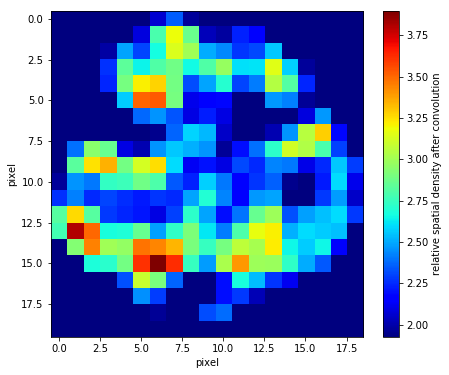

In [26]:
fig, ax = plt.subplots(figsize=(7,6))
im = plt.imshow(clipped,cmap=plt.cm.jet,aspect='auto')
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.colorbar(label='relative spatial density after convolution');

In [27]:
# find peaks
mask = np.ones(clipped.shape)
#mask[150:200,100:150] = 0 
mean, median, std = stats.sigma_clipped_stats(clipped*mask,sigma=1.0,iters=5)    
tbl = find_peaks(clipped*mask,median+5.,box_size=small_k*2) # median + ? is the detection threshold

# add ra & dec positions of peaks found
a, b = extent[:2]
xvec = np.arange(a,b,(b-a)/clipped.shape[1])
a, b = extent[2:]
yvec = np.arange(a,b,(b-a)/clipped.shape[0])

tbl['ra'] = xvec[tbl['x_peak']]
tbl['dec'] = yvec[-tbl['y_peak']-1]
print(tbl)

x_peak y_peak peak_value  ra dec
------ ------ ---------- --- ---


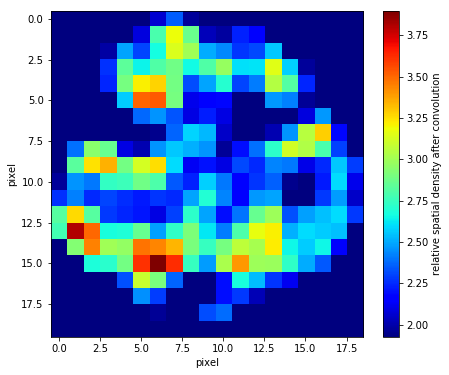

In [28]:
ecs = ['r'] # colors of box frames
ax.scatter(tbl['x_peak'],tbl['y_peak'],marker='s',s=tbl['peak_value']*40,c='none',edgecolors=ecs,lw=3) # keeps writing to previous ax
fig  # repeats (the updated) figure

It only worked for NGC 300 and Sculptor, but not the other ones...

# Get images

In [34]:
# gets coordinates of a named source
def resolve_coordinates(name):
    try:
        coords = name_resolve.get_icrs_coordinates(name)
    except Exception as e:
        raise

    ra = coords.ra.to('deg').value
    dec = coords.dec.to('deg').value      

    return coords, ra, dec

In [35]:
# set up SIA
DEF_ACCESS_URL = "http://datalab.noao.edu/sia/des_dr1"
svc = sia.SIAService(DEF_ACCESS_URL)

# a little func to download the deepest stacked images
"""
def download_deepest_images(ra,dec,fov=0.1,bands=list('gri')):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).votable.to_table()
    print("The full image list contains {:d} entries.".format(len(imgTable)))
    sel0 = (imgTable['proctype'] == b'Stacked') & (imgTable['prodtype']==b'image') # basic selection
    images = []
    for band in bands:
        print("Band {:s}: ".format(band)) #, end='')
        sel = sel0 & (imgTable['obs_bandpass'] == band.encode()) # add 'band' to selection
        Table = imgTable[sel] # select
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'] # get the download URL
        print('downloading deepest stacked image...')
        img = io.fits.getdata(utils.data.download_file(url.decode(),cache=True,show_progress=False,timeout=120)) # .decode() b/c in Python 3 url is of "byte" type and getdata() expects "string" type
        images.append(img)
        
    print("Downloaded {:d} images.".format(len(images)))
    return images
"""

def download_deepest_images(ra,dec,fov=0.1,bands=list('gri')):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).votable.to_table()
    print("The full image list contains {:d} entries.".format(len(imgTable)))
    
    sel0 = (imgTable['proctype'] == b'Stack') & (imgTable['prodtype']==b'image') # basic selection
    images = []
    for band in bands:
        print("Band {:s}: ".format(band), end='')
        sel = sel0 & (imgTable['obs_bandpass'] == band.encode()) # add 'band' to selection
        Table = imgTable[sel] # select
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'] # get the download URL
        print('downloading deepest stacked image...')
        img = io.fits.getdata(utils.data.download_file(url.decode(),cache=True,show_progress=False,timeout=500)) # .decode() b/c in Python 3 url is of "byte" type and getdata() expects "string" type
        images.append(img)
        
    print("Downloaded {:d} images.".format(len(images)))
    return images

# multi panel image plotter
def plot_images(images,geo=None,panelsize=5,titles=list('gri'),cmap=plt.cm.gray_r):
    if geo is None:
        geo = (len(images),1)  # ncols, nrows
        
    fig = plt.figure(figsize=(geo[0]*panelsize,geo[1]*panelsize))
    for j,img in enumerate(images):
        ax = fig.add_subplot(geo[1],geo[0],j+1)
        ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,norm=plt.mpl.colors.PowerNorm(0.1))
        ax.set_title('{:s}'.format(titles[j]))
        plt.axis('off')

In [36]:
bands = list('gri')
fov = 0.5
images_NGC300 = download_deepest_images(core_samples_center[0,0], core_samples_center[0,1], fov=fov, bands=bands)

AttributeError: 'VOTableFile' object has no attribute 'to_table'

# Appendix

## Here's the source code from astropy.coordinates.angle_utilities.

## This implements the vincenty formula. Change the cell type to code to run it if you wish.

def angular_separation(lon1, lat1, lon2, lat2):

    """
    From astropy.coordinates.angle_utilities
    Angular separation between two points on a sphere.
    Parameters
    ----------
    lon1, lat1, lon2, lat2 : `Angle`, `~astropy.units.Quantity` or float
        Longitude and latitude of the two points. Quantities should be in
        angular units; floats in radians.
    Returns
    -------
    angular separation : `~astropy.units.Quantity` or float
        Type depends on input; `Quantity` in angular units, or float in
        radians.
    Notes
    -----
    The angular separation is calculated using the Vincenty formula [1]_,
    which is slightly more complex and computationally expensive than
    some alternatives, but is stable at at all distances, including the
    poles and antipodes.
    .. [1] https://en.wikipedia.org/wiki/Great-circle_distance
    """


    sdlon = np.sin(lon2 - lon1)
    cdlon = np.cos(lon2 - lon1)
    slat1 = np.sin(lat1)
    slat2 = np.sin(lat2)
    clat1 = np.cos(lat1)
    clat2 = np.cos(lat2)

    num1 = clat2 * sdlon
    num2 = clat1 * slat2 - slat1 * clat2 * cdlon
    denominator = slat1 * slat2 + clat1 * clat2 * cdlon

    return np.arctan2(np.hypot(num1, num2), denominator)